# Grover's algorithm

In [1]:
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.primitives import Sampler
from qiskit_aer import Aer

In [2]:
def query_function(marked_state, qc, qr):

    """
    Applies the query operation to mark the specified state.

    Parameters:
    marked_state (str): The binary string representing the marked state.
    qc (QuantumCircuit): The quantum circuit to which the operation is applied.
    qr (QuantumRegister): The quantum register containing the qubits.

    Returns:
    None
    """
    
    # apply X gate to qubits if marked_state has a zero 
    for i in range(len(marked_state)):
        if marked_state[i] == '0':
            qc.x(qr[len(marked_state)-1-i])
    
    # apply multi controlled X gate to get sign of -1 for the marked_state 
    qc.mcx(control_qubits=list(range(0,qr.size-1)), target_qubit=qr[qr.size-1])
    
    # apply X gate again to revert 
    for i in range(len(marked_state)):
        if marked_state[i]=='0':
            qc.x(qr[len(marked_state)-1-i])

In [3]:
def diffusion_operator(qc, qr):
    """
    Applies the diffusion operator. This implementation produces 
    the diffusion operator, but without the minus sign in -HS_0H

    Parameters:
    qc (QuantumCircuit): The quantum circuit to which the operation is applied.
    qr (QuantumRegister): The quantum register containing the qubits.

    Returns:
    None
    """
    
    # apply H and X gate
    for i in range(qr.size-1):
        qc.h(qr[i])
        qc.x(qr[i])
    
    # apply multi controlled Z gate to get sign of -1 for the all 1 state. 
    # by applying X gates before and after this operation, the sign of -1 gets applied to the all 0 state instead  
    qc.h(qr[qr.size-2])
    qc.mcx(control_qubits=list(range(0,qr.size-2)), target_qubit=qr[qr.size-2])
    qc.h(qr[qr.size-2])
    
    # apply X and H gate
    for i in range(qr.size-1):
        qc.x(qr[i])
        qc.h(qr[i])

In [4]:
# define the marked state and the number of qubits
marked_state = '100'
n = len(marked_state)

# define quantum and classical registers
qr0 = QuantumRegister(n+1, 'q')
cr0 = ClassicalRegister(n, 'c')
qc = QuantumCircuit(qr0, cr0)

# initialize the one state in the ancilla qubit
qc.x(qr0[qr0.size-1])

# put all the qubits in superposition (changes ancilla to minus state)
qc.h(qr0)

# compute the required number of iterations
iterations = math.floor(math.pi/4*math.sqrt(2**(n)))
print(f'Number of iterations: {iterations}')

# apply the grover operator repeatedly
for i in range(iterations):
    query_function(marked_state, qc, qr0)
    qc.barrier()
    diffusion_operator(qc, qr0)
    qc.barrier()

# measure the quantum register
qc.measure(qr0[0:qr0.size-1], cr0)

qc.draw()

Number of iterations: 2


┌───┐┌───┐     ┌───┐ ░ ┌───┐┌───┐          ┌───┐┌───┐      ░ ┌───┐     »
q_0: ┤ H ├┤ X ├──■──┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤ X ├──■──»
     ├───┤├───┤  │  ├───┤ ░ ├───┤├───┤       │  ├───┤├───┤      ░ ├───┤  │  »
q_1: ┤ H ├┤ X ├──■──┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤ X ├──■──»
     ├───┤└───┘  │  └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░ └───┘  │  »
q_2: ┤ H ├───────■────────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░────────■──»
     ├───┤┌───┐┌─┴─┐      ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░      ┌─┴─┐»
q_3: ┤ X ├┤ H ├┤ X ├──────░─────────────────────────────────────░──────┤ X ├»
     └───┘└───┘└───┘      ░                                     ░      └───┘»
c: 3/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐ ░ ┌───┐┌───┐          ┌───┐┌───┐      ░ ┌─┐      
«q_0: ┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤M├──────
«     ├───┤ ░ ├───┤├───┤       │  ├───┤├───┤      ░ └╥┘┌─┐   
«q_1: ┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├───
«     └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║ └╥┘┌─┐
«q_2: ──────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
«           ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║ └╥┘
«q_3: ──────░─────────────────────────────────────░──╫──╫──╫─
«           ░                                     ░  ║  ║  ║ 
«c: 3/═══════════════════════════════════════════════╩══╩══╩═
«                                                    0  1  2

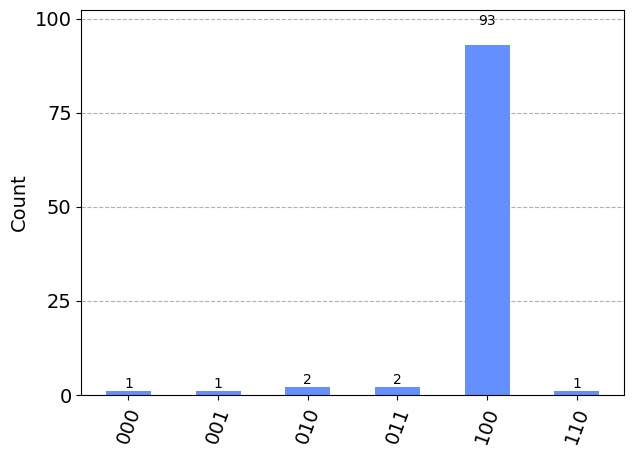

In [5]:
# select the qasm simulator as the backend
simulator = Aer.get_backend('qasm_simulator')

# transpile the circuit for the selected simulator
qc_transpiled = transpile(qc, simulator, optimization_level=1)

# run the transpiled circuit on the simulator
job = simulator.run(qc_transpiled, shots=100)

# get results
job_result = job.result() 
counts = job_result.get_counts(qc_transpiled)
plot_distribution(counts)
plot_histogram(counts)